In [1]:
import pandas as pd
df = pd.read_csv("Time-Series/data/600240.csv")  
df.tail()

,date,close,d_return
635,2019-07-17,0.99,-0.010000
636,2019-07-18,1.02,0.030303
637,2019-07-19,1.01,-0.009804
638,2019-07-22,0.97,-0.039604
639,2019-07-23,0.96,-0.010309


In [2]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2016-12-06 to 2019-07-23
Data columns (total 2 columns):
close       640 non-null float64
d_return    640 non-null float64
dtypes: float64(2)
memory usage: 15.0 KB


In [3]:
#缺失值确认
df.isnull().values.sum()

0

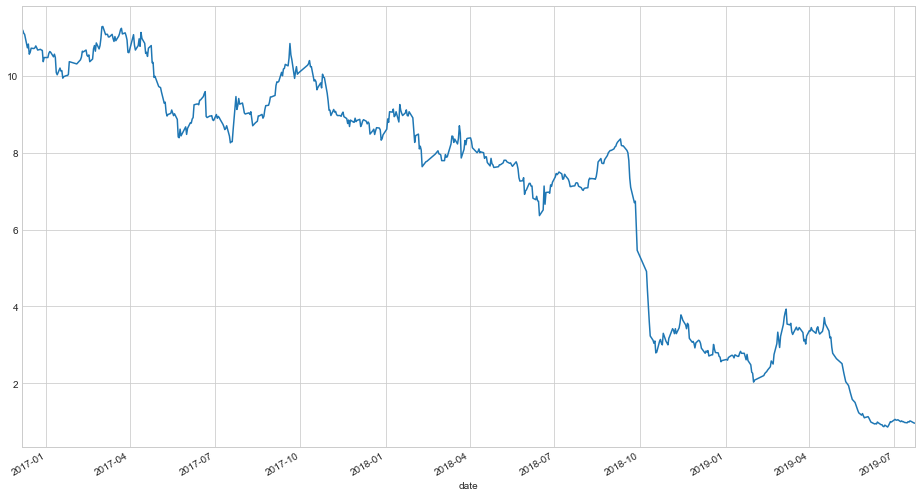

In [4]:
#绘图：收盘价走势图
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
close = df.close
close.plot(figsize=(16,9))

(<matplotlib.collections.LineCollection at 0x94b7c48>,
 <matplotlib.collections.PolyCollection at 0x94b7e08>)

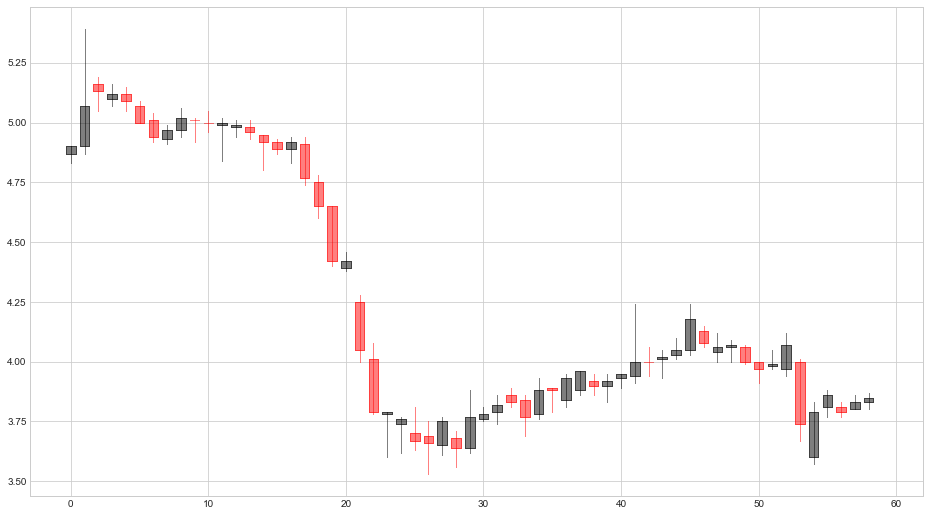

In [5]:
#K线图 #另一组数据
from mpl_finance import candlestick2_ohlc
df2 = pd.read_csv("Time-Series/data/000862.csv")  
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)
year_2018_1_3 = df2['2018-01':'2018-03']  # 绘制 2018 年 1 月至 3 月的 K 线图

fig, ax = plt.subplots(figsize=(16, 9))
candlestick2_ohlc(ax, year_2018_1_3.open, year_2018_1_3.high,
                  year_2018_1_3.low, year_2018_1_3.close, width=.7, alpha=.5)

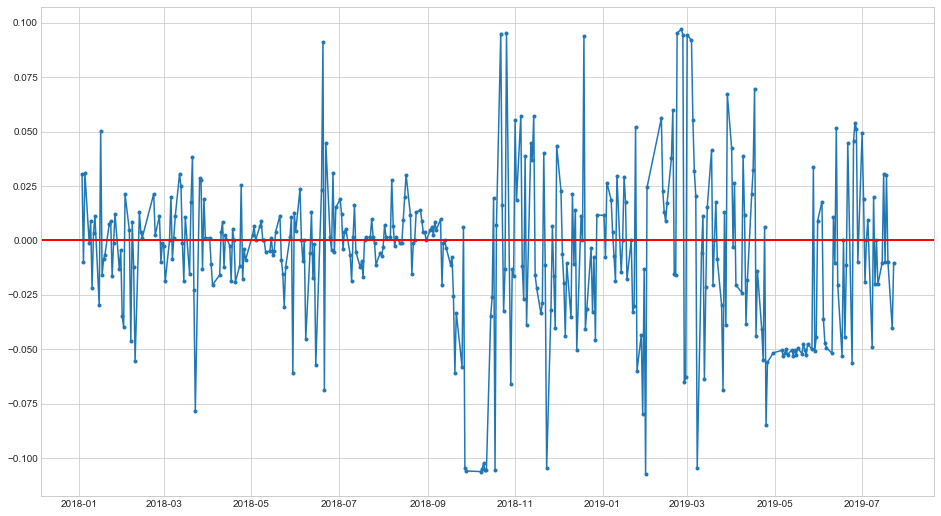

In [6]:
#相对变化曲线log(close(t))−log(close(t−1))
import numpy as np

year_2018 = df['2018-01':]
year_2018_close = year_2018.close

log_change = np.log(year_2018_close) - np.log(year_2018_close.shift(1))

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(log_change, ".-")
ax.axhline(y=0, color='red', lw=2)

红线为基准线红线上部代表当天较前一天股票上涨，而下部对应的则正好相反。

将相对涨跌比例情况绘制成饼状图进行可视化。

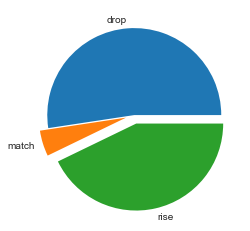

In [7]:
#饼图
labels = 'drop', 'match', 'rise' # 下跌，持平，上涨
sizes = [(log_change < 0).sum(), (log_change == 0).sum(), (log_change > 0).sum()]
explode = (0, 0.1, 0.1)

plt.pie(x=sizes, labels=labels, explode=explode)
plt.show()

### 短期交易策略

使用 Pandas 提供的 rolling 函数计算指定 window 中的股票均价，并绘图

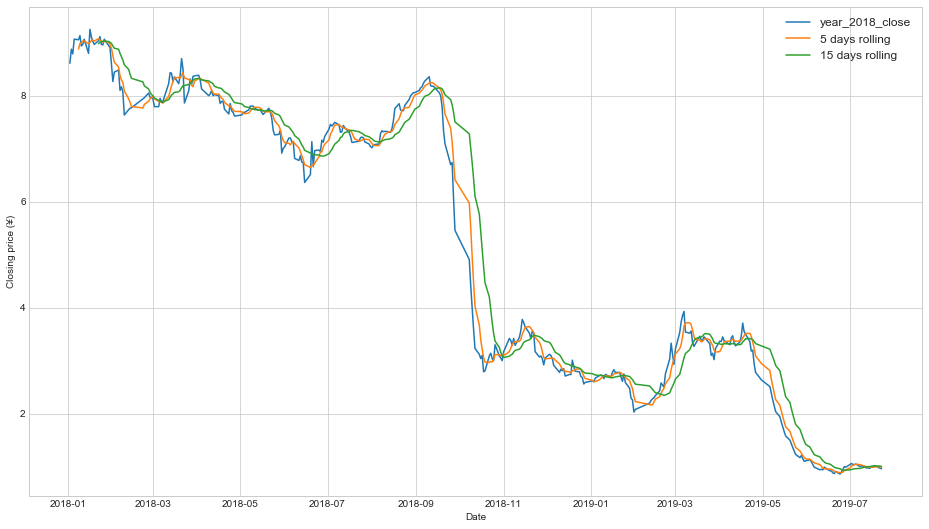

In [8]:
from mpl_finance import candlestick2_ohlc


short_rolling = year_2018_close.rolling(window=5).mean() # 滑动窗口求平均值
long_rolling = year_2018_close.rolling(window=15).mean()

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(year_2018_close.index, year_2018_close, label='year_2018_close')
ax.plot(short_rolling.index, short_rolling, label='5 days rolling')
ax.plot(long_rolling.index, long_rolling, label='15 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (¥)')
ax.legend(fontsize='large')

可以看出，当 window=15 时的变化曲线明显比 window=5 时平缓，这也就抵消了股价在短时间内的波动。 而长期和短期变化曲线的交点，往往就是我们购入或卖出股票的时间点。如果我们是短期投资者，就可以建立一个交易策略。

    当短期变化曲线从上方交与长期变化曲线，说明股票短期看跌，则卖出。
    当短期变化曲线从下方交与长期变化曲线，说明股票长期看涨，则买入。

将这些交易节点标记并可视化出来。

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


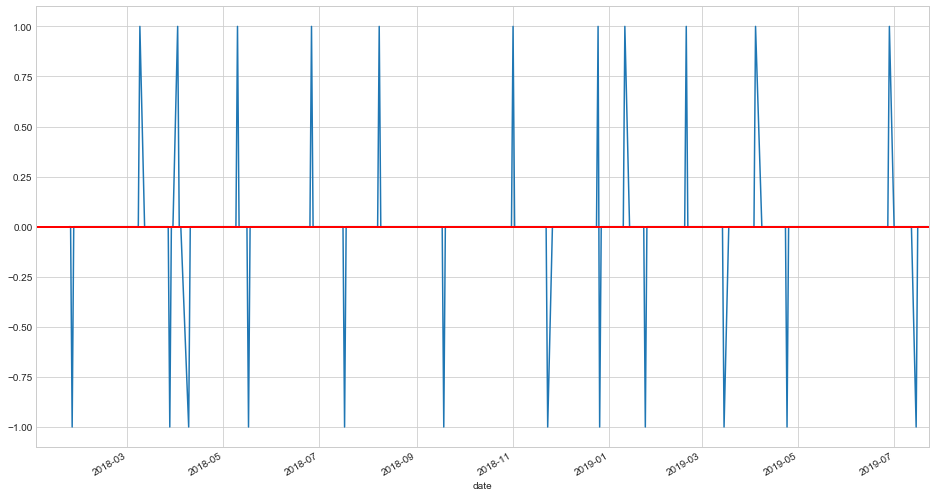

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))

short_long = np.sign(short_rolling - long_rolling) # np.sign 为符号函数
buy_sell = np.sign(short_long - short_long.shift(1))
buy_sell.plot(ax=ax)
ax.axhline(y=0, color='red', lw=2)

In [10]:
#适合买入时间点
buy_sell[buy_sell == 1]

date
2018-03-09    1.0
2018-04-02    1.0
2018-05-10    1.0
2018-06-26    1.0
2018-08-08    1.0
2018-11-01    1.0
2018-12-25    1.0
2019-01-11    1.0
2019-02-19    1.0
2019-04-04    1.0
2019-06-28    1.0
Name: close, dtype: float64

In [11]:
#适合卖出时间点
buy_sell[buy_sell == -1]

date
2018-01-25   -1.0
2018-03-28   -1.0
2018-04-09   -1.0
2018-05-17   -1.0
2018-07-17   -1.0
2018-09-18   -1.0
2018-11-23   -1.0
2018-12-26   -1.0
2019-01-24   -1.0
2019-03-15   -1.0
2019-04-24   -1.0
2019-07-15   -1.0
Name: close, dtype: float64

In [52]:
#收益计算
year_2018_close['2018-09-18'] - year_2018_close['2018-08-08']

0.6600000000000001

以上通过历史数据建立的交易策略。在未来的变化过程中，可能并不那么有效。尤其是在股票整体长期下行的时期，这种短期交易策略往往依旧会亏本。

### 长期交易策略 Prophet

In [12]:
data = df['close'].reset_index()
data = data.rename(columns={'date': 'ds', 'close': 'y'})
data

,ds,y
0,2016-12-06,11.181
1,2016-12-07,11.191
2,2016-12-08,11.113
3,2016-12-09,11.083
4,2016-12-12,10.732
...,...,...
635,2019-07-17,0.990
636,2019-07-18,1.020
637,2019-07-19,1.010
638,2019-07-22,0.970


In [13]:
#定义&训练模型
import fbprophet
model = fbprophet.Prophet(changepoint_prior_scale=0.05,
                          daily_seasonality=True)  # 定义模型
model.fit(data)  # 训练模型

In [14]:
forecast_df = model.make_future_dataframe(periods=365, freq='D')  # 生成需预测序列
forecast = model.predict(forecast_df)  # 模型预测

Text(0.5, 1, 'Close Price of AAPL')

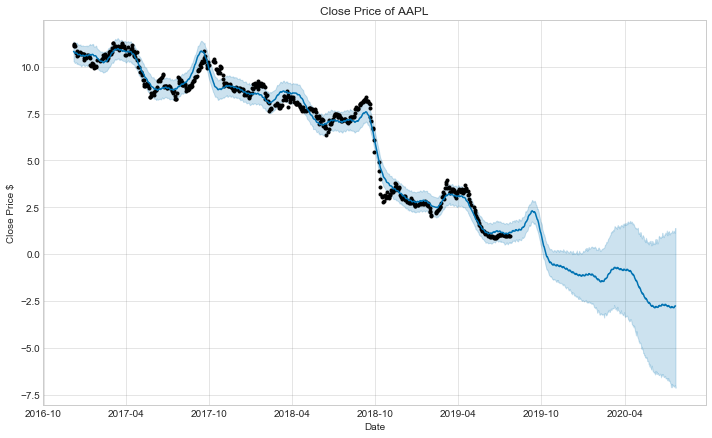

In [15]:
model.plot(forecast, xlabel='Date', ylabel='Close Price $')  # 绘制预测图
plt.title('Close Price of AAPL')

黑点代表实际值，蓝线表示预测值，蓝色半透明区域表示置信区间。

可以尝试不同的 changepoint_prior_scale 值进行比较

为了将不同颜色绘制出来，我们添加一个 plot_color= 参数，这里需要改造 fbprophet 默认的 plot 函数。

In [16]:
def plot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', 
         ylabel='y', plot_color='#0072B2'):
    """Plot the Prophet forecast.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c=plot_color)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color=plot_color, alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

开始绘制不同 changepoint_prior_scale 值下的趋势曲线，可以看到置信区间范围的变化。

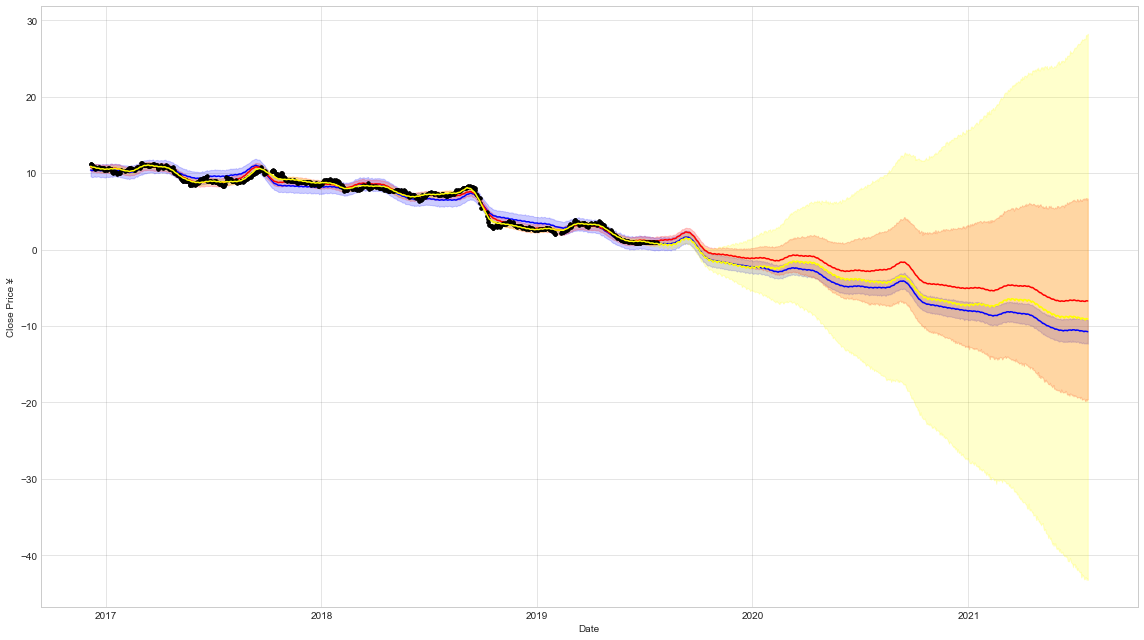

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))

# 此处代码运行时间较长
for point, color in zip([0.01, 0.05, 0.1], ['blue', 'red', 'yellow']):
    temp_model = fbprophet.Prophet(
        changepoint_prior_scale=point, daily_seasonality=True)
    temp_model.fit(data)
    forecast = temp_model.make_future_dataframe(periods=365*2, freq='D')  # 2 年
    forecast = temp_model.predict(forecast)
    plot(temp_model, forecast, ax=ax, xlabel='Date',
         ylabel='Close Price ¥', plot_color=color)

画出股价变化点（Change points）。变化点代表时间序列从上升与下降趋势的变化时刻。

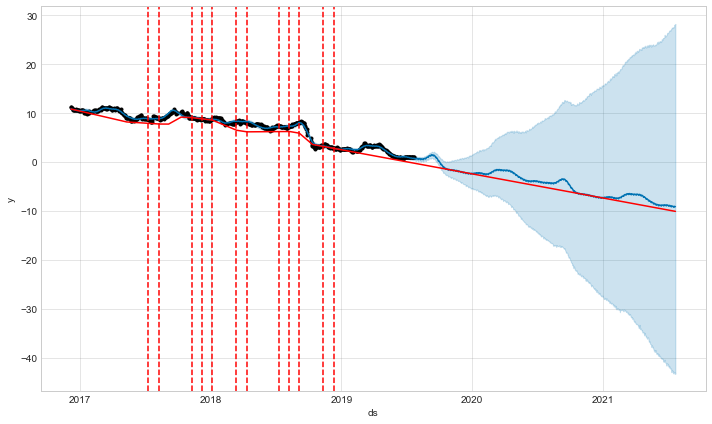

In [18]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)  # 绘制预测图
a = add_changepoints_to_plot(fig.gca(), model, forecast)  # 增加变化点

除此之外，通过 Prophet 还可以查看多种维度（天，周，年）下的季节性变化趋势。接下来，通过 plot_components 绘制出股票数据按年，周，天的季节性波动趋势。

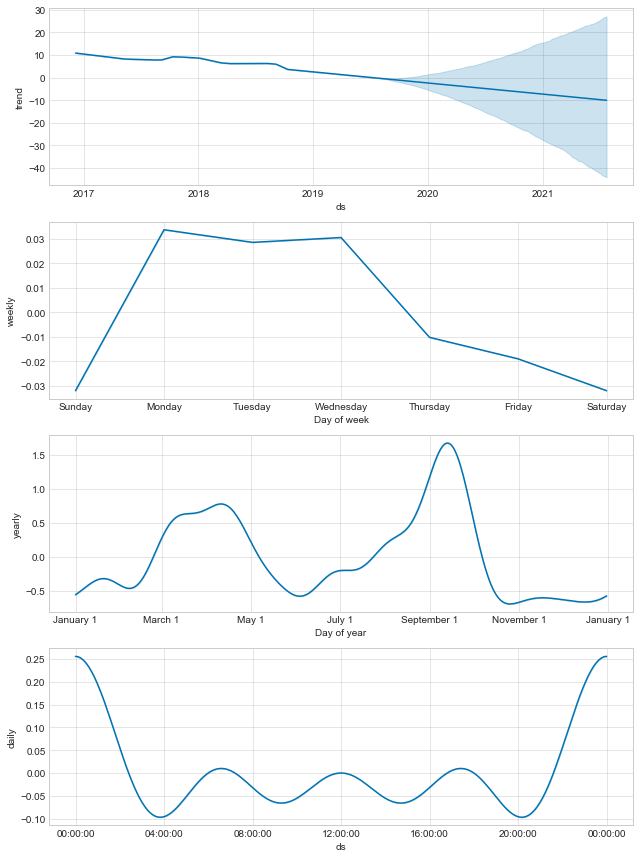

In [19]:
from fbprophet.plot import plot_components

model.plot_components(forecast);  # 绘制多维度变化趋势图